In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import classification_report, confusion_matrix, average_precision_score
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np

In [ ]:
def load_glaucoma_dataset(data_dir, image_size):
    images = []
    labels = []
    class_names = ['Glaucoma_Positive', 'Glaucoma_Negative']

    for class_name in class_names:
        class_dir = os.path.join(data_dir, class_name)
        class_label = class_names.index(class_name)

        for filename in os.listdir(class_dir):
            if filename.endswith(".jpg"):
                img_path = os.path.join(class_dir, filename)
                img = cv2.imread(img_path)
                img = cv2.resize(img, (image_size, image_size))
                img = img / 255.0
                images.append(img)
                labels.append(class_label)

    return np.array(images), np.array(labels)

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import os

def load_glaucoma_dataset_generator(dataset_path, image_size, batch_size=32):
    datagen = ImageDataGenerator(rescale=1./255)

    generator = datagen.flow_from_directory(
        dataset_path,
        target_size=(image_size, image_size),
        batch_size=batch_size,
        class_mode='binary',  # Assuming it's a binary classification task
        shuffle=False  # Ensure that the order is preserved
    )

    # Retrieve the total number of samples
    num_samples = generator.samples

    return generator, num_samples

# Example usage:
your_dataset_path = r"/content/drive/MyDrive/Dataset_Sardjito"
your_image_size = 224
batch_size = 32

# Define the path to the test dataset
test_dataset_path = os.path.join(your_dataset_path, 'test')

# Create a generator for the test dataset
test_generator, num_test_samples = load_glaucoma_dataset_generator(test_dataset_path, your_image_size, batch_size)

# Define the path to your pre-trained model
model_path = "/content/drive/MyDrive/final_mode223.h5"  # Change this to the path of your saved model

# Load the pre-trained model
loaded_model = load_model(model_path)

# Initialize variables for confusion matrix
all_true_labels = []
all_predicted_labels = []

# Calculate the total number of batches
total_batches = num_test_samples // batch_size

# Iterate over batches
for i in range(total_batches + 1):  # +1 to include the last batch
    batch_images, batch_labels = test_generator.next()

    # Perform predictions on the batch
    predictions = loaded_model.predict(batch_images)
    predicted_labels = np.round(predictions).flatten()

    # Append true and predicted labels for confusion matrix
    all_true_labels.extend(batch_labels)
    all_predicted_labels.extend(predicted_labels)

    # Calculate loading and prediction process
    process_percentage = (i + 1) / (total_batches + 1) * 100
    print(f"Processing: {process_percentage:.2f}%")

# Convert true and predicted labels to numpy arrays
all_true_labels = np.array(all_true_labels)
all_predicted_labels = np.array(all_predicted_labels)

# Evaluate the model on the entire test set
test_loss, test_accuracy = loaded_model.evaluate(test_generator)

# Print test accuracy, test loss, confusion matrix, and classification report
print(f"\nTest Accuracy: {test_accuracy}")
print(f"Test Loss: {test_loss}")
print("\nConfusion Matrix:")
conf_matrix = confusion_matrix(all_true_labels, all_predicted_labels)
print(conf_matrix)
print("\nClassification Report:")
class_report = classification_report(all_true_labels, all_predicted_labels)
print(class_report)

# Save the confusion matrix
conf_matrix_save_path = "/content/drive/MyDrive/confusion_matrix.npy"
np.save(conf_matrix_save_path, conf_matrix)
print(f"\nConfusion Matrix saved at: {conf_matrix_save_path}")


Found 196 images belonging to 2 classes.
1/1 [==============================] - 12s 12s/step
Processing: 14.29%
1/1 [==============================] - 9s 9s/step
Processing: 28.57%
1/1 [==============================] - 9s 9s/step
Processing: 42.86%
1/1 [==============================] - 11s 11s/step
Processing: 57.14%
1/1 [==============================] - 10s 10s/step
Processing: 71.43%
1/1 [==============================] - 9s 9s/step
Processing: 85.71%
1/1 [==============================] - 3s 3s/step
Processing: 100.00%
7/7 [==============================] - 65s 9s/step - loss: 1.5860 - accuracy: 0.5204

Test Accuracy: 0.5204081535339355
Test Loss: 1.5860118865966797

Confusion Matrix:
[[16 18]
 [76 86]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.17      0.47      0.25        34
         1.0       0.83      0.53      0.65       162

    accuracy                           0.52       196
   macro avg       0.50      0.50      

In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split

def split_data(input_folder, output_folder, train_percent=0.9, test_percent=0.05, val_percent=0.05):
    # Create train, test, and val folders in the output directory
    train_folder = os.path.join(output_folder, 'train')
    test_folder = os.path.join(output_folder, 'test')
    val_folder = os.path.join(output_folder, 'val')

    os.makedirs(train_folder, exist_ok=True)
    os.makedirs(test_folder, exist_ok=True)
    os.makedirs(val_folder, exist_ok=True)

    for class_folder in os.listdir(input_folder):
        input_class_folder = os.path.join(input_folder, class_folder)

        if os.path.isdir(input_class_folder):
            # Create class-specific train, test, and val folders
            train_class_folder = os.path.join(train_folder, class_folder)
            test_class_folder = os.path.join(test_folder, class_folder)
            val_class_folder = os.path.join(val_folder, class_folder)

            os.makedirs(train_class_folder, exist_ok=True)
            os.makedirs(test_class_folder, exist_ok=True)
            os.makedirs(val_class_folder, exist_ok=True)

            # List all files in the input folder
            all_files = os.listdir(input_class_folder)
            total_files = len(all_files)

            # Split files into train, test, and val sets
            train_files, test_val_files = train_test_split(all_files, test_size=(test_percent + val_percent), random_state=42)
            test_files, val_files = train_test_split(test_val_files, test_size=val_percent/(test_percent + val_percent), random_state=42)

            # Copy files to the corresponding class-specific folders
            for file_name in train_files:
                shutil.copy(os.path.join(input_class_folder, file_name), os.path.join(train_class_folder, file_name))

            for file_name in test_files:
                shutil.copy(os.path.join(input_class_folder, file_name), os.path.join(test_class_folder, file_name))

            for file_name in val_files:
                shutil.copy(os.path.join(input_class_folder, file_name), os.path.join(val_class_folder, file_name))

# Example usage:
input_folder = r"/content/drive/MyDrive/Dataset_LAG/bare"
output_folder = r"/content/drive/MyDrive/Dataset_LAG"  # Change this to the desired output path

split_data(input_folder, output_folder)



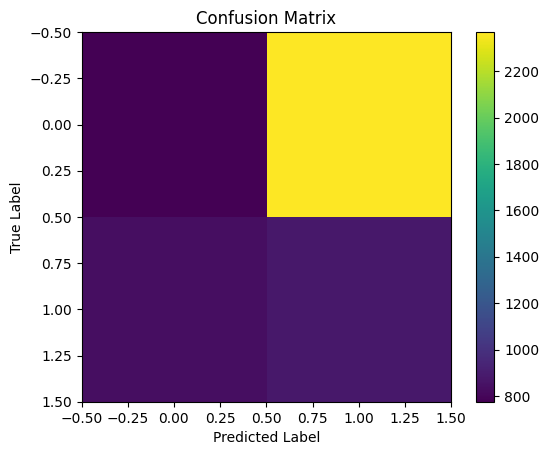

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Load the confusion matrix
data = np.load('/content/drive/MyDrive/confusion_matrix.npy')

# Display the confusion matrix as an image
plt.imshow(data, cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [ ]:
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Define the path to your pre-trained model
model_path = "/content/drive/MyDrive/Dataset_Latihan/best_model.h5"  # Change this to the path of your saved model

# Load the pre-trained model
loaded_model = load_model(model_path)

# Assuming you have loaded your test datasets: glaucoma_test_images, glaucoma_test_labels

# Perform predictions on the test set
predictions = loaded_model.predict(glaucoma_test_images)
predicted_labels = np.round(predictions).flatten()

# Convert true labels to binary (assuming it's not binary already)
true_labels = np.array(glaucoma_test_labels).flatten()

# Evaluate the model on the test set
test_loss, test_accuracy = loaded_model.evaluate(glaucoma_test_images, glaucoma_test_labels)

# Print test accuracy, test loss, confusion matrix, and classification report
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Loss: {test_loss}")
print("\nConfusion Matrix:")
print(confusion_matrix(true_labels, predicted_labels))
print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels))